In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
%matplotlib inline

from utils_plotting import plot_with_power_law, val_display_dict, display_dict
from utils_scaling import fit, plot_contours, kaplan_curve

import jax.numpy as jnp
import optax

sns.set_style("whitegrid")

In [2]:
df = pd.read_csv("data/sweep.csv")
df_big = pd.read_csv("data/extrapolation.csv")

opt_params_df = pd.read_csv("data/opt_params_data.csv")
opt_params_df = opt_params_df[opt_params_df["kaplan"] == True] # only use the kaplan-style curve fits

In [3]:
params_df = pd.read_csv("data/opt_params_data.csv")

In [ ]:
# Only use this cell for getting smaller fits!

chinchilla_df = df[(df["data_ratio"] > 16) & (df["data_ratio"] < 23) & (df["n_layers"] != 20)] # Remove a duplicate flop count

In [5]:
datasets = list(df["data"].unique())
datasets = sorted(datasets)
vals = [c for c in df.columns if "CrossEntropyLoss" in c and "eval" in c]

In [6]:
def get_drop_df(df, data):
    drop_df = df[df["data"] == data].copy()
    return drop_df

def power_law_with_constant(x, a, b, c, d):
    xc = np.maximum(x - c, 0)
    return b * np.power(xc, a) + d

In [7]:
test_losses = [c for c in df.columns if "ce_loss" in c and "ctx" not in c and "5shot" not in c and "imbue" not in c and "suite" not in c and "boolq" not in c]
test_losses

['eval/downstream_ce_loss/arc_challenge_test_ce_loss',
 'eval/downstream_ce_loss/arc_easy_test_ce_loss',
 'eval/downstream_ce_loss/hellaswag_test_ce_loss',
 'eval/downstream_ce_loss/mmlu_humanities_test_ce_loss',
 'eval/downstream_ce_loss/mmlu_other_test_ce_loss',
 'eval/downstream_ce_loss/mmlu_social_sciences_test_ce_loss',
 'eval/downstream_ce_loss/mmlu_stem_test_ce_loss',
 'eval/downstream_ce_loss/openbook_qa_test_ce_loss',
 'eval/downstream_ce_loss/piqa_test_ce_loss',
 'eval/downstream_ce_loss/sciq_test_ce_loss',
 'eval/downstream_ce_loss/winogrande_test_ce_loss']

In [8]:
val_losses = [c for c in df.columns if "CrossEntropyLoss" in c and "eval" in c and "c4" not in c and "1T" not in c]
val_losses

['eval/fineweb_100b_val/CrossEntropyLoss',
 'eval/fineweb_edu_100b_val/CrossEntropyLoss',
 'eval/proof_pile_2_val/CrossEntropyLoss',
 'eval/slimpajama_val/CrossEntropyLoss',
 'eval/smollm_val/CrossEntropyLoss',
 'eval/starcoder_val/CrossEntropyLoss']

# Functions

In [9]:
def plot_loss_diff_f(ax, df, data_1, data_2, color="blue", 
                     key_1="val_loss", key_2="val_loss",
                    downstream=False, params=None, iso_flop=None, extrapolate=False,
                    add_x=None, 
                    fit_ey=False, 
                    ey=None, 
                    plot_fit=True):

    drop_df1 = get_drop_df(df, data_1)
    drop_df2 = get_drop_df(df, data_2)

    join_df = drop_df1.join(drop_df2.set_index("tokens"), how="inner", on="tokens", rsuffix="_1")

    if iso_flop is not None:
        join_df = join_df[join_df["iso_flop"] == iso_flop]
    if params is not None:
        join_df = join_df[join_df["params"] == params]

    x = join_df[key_1]
    y = join_df[f"{key_2}_1"]
    
    ex = opt_params_df[(opt_params_df["data"] == data_1) & (opt_params_df["loss_name"] == key_1)]["E"].values[0]

    if ey is None:
        ey = opt_params_df[(opt_params_df["data"] == data_2) & (opt_params_df["loss_name"] == key_2)]["E"].values[0]
    elif ey == "data_1":
        ey = opt_params_df[(opt_params_df["data"] == data_1) & (opt_params_df["loss_name"] == key_2)]["E"].values[0]

    if fit_ey:
        results_df = plot_with_power_law(ax, x, y, color, display_dict[data_2], add_x=add_x, ex=ex, ey=None, fit=plot_fit)
    else:
        print("plot fit: ", plot_fit)
        results_df = plot_with_power_law(ax, x, y, color, display_dict[data_2], add_x=add_x, ex=ex, ey=ey, fit=plot_fit)

    return results_df

In [10]:
def plot_loss_same_f(ax, df, data, color="blue", test_key="olmo_suite_ce_loss", label=None, add_x=None, fit_ey=False):
    loss_key = "val_loss" 

    drop_df = get_drop_df(df, data)
    x = drop_df[loss_key]
    y = drop_df[test_key]

    if label is None:
        label = data

    ex = opt_params_df[(opt_params_df["data"] == data) & (opt_params_df["loss_name"] == "val_loss")]["E"].values[0]

    ey = opt_params_df[(opt_params_df["data"] == data) & (opt_params_df["loss_name"] == test_key)]["E"].values[0]

    if fit_ey:
        coeffs = plot_with_power_law(ax, x, y, color, label, add_x=add_x, ex=ex, ey=None)
    else:
        coeffs = plot_with_power_law(ax, x, y, color, label, add_x=add_x, ex=ex, ey=ey)

    return coeffs

In [11]:
def get_data(drop_df, key = "train/CrossEntropyLoss"):
    drop_df = drop_df.dropna(subset=[key])

    N = jnp.array(drop_df["params"], dtype=jnp.float32)
    D = jnp.array(drop_df["tokens"], dtype=jnp.float32)
    L = jnp.array(drop_df[key], dtype=jnp.float32)
    return N, D, L

def plot_scaling(ax, df, d1, loss="val_loss", ncontour=40, extrap=True, test=False):
    drop_df = df[df["data"] == d1]
    N, D, L = get_data(drop_df, loss)
    params, _ = fit(N, D, L, kaplan=True)
    print(f"Loss: {params['loss']}")
    df_big_data = df_big[df_big["data"] == d1]
    x = np.array(df_big_data["iso_flop"])
    y = np.array(df_big_data["params"])
    z = np.array(df_big_data[loss])
    if extrap:
        extrapolation = (x,y,z)
    else: 
        extrapolation = None
    masks = np.ones(5)
    vals = np.zeros(5)
    scatter, _, _, _ = plot_contours(ax, N, D, L, params, masks, vals, extrapolation, kaplan=True, ncontour=ncontour)
    ax.set_title(f"{display_dict[d1]} Train")
    if test:
        plt.colorbar(scatter, ax=ax, label="Test Loss")
    return params

def translate(params, power_law):
    kappa, k, ex, ey = power_law["params"][0]
    params["A"] *= np.power(k, 1/(kappa * params["alpha"]))
    params["B"] *= np.power(k, 1/(kappa * params["beta"]))
    params["E"] = ey
    params["alpha"] *= kappa
    params["beta"] *= kappa
    return params

# Train-to-train

In [12]:
def translate_params(d1, d2):
    # Create the figure and subplots
    fig, axs = plt.subplots(1, 3, figsize=(12, 3))

    # Plot the data
    params = plot_scaling(axs[0], df, d1, loss="val_loss", extrap=False)

    color=sns.color_palette()[0]
    x = df_big[df_big["data"] == d1]["val_loss"].values[0]
    y = df_big[df_big["data"] == d2]["val_loss"].values[0]
    power_law = plot_loss_diff_f(axs[1], chinchilla_df, d1, d2, color=color, 
                        downstream=False, params=None, iso_flop=None, extrapolate=True,
                        add_x=None, 
                        fit_ey=True) # Make sure we fit the entropy of y!

    axs[1].set_xlabel(f"{display_dict[d1]} Train")
    axs[1].set_ylabel(f"{display_dict[d2]} Train")
    axs[1].set_title(f"Train-to-Train")

    params = translate(params, power_law)
    N, D, L = get_data(chinchilla_df[chinchilla_df["data"] == d2], key="val_loss")
    masks = np.ones(5)
    vals = np.zeros(5)
    df_big_data = df_big[df_big["data"] == d2]
    x = np.array(df_big_data["iso_flop"])
    y = np.array(df_big_data["params"])
    z = np.array(df_big_data["val_loss"])
    extrapolation = (x,y,z)
    plot_contours(axs[2], N, D, L, params, masks, vals, extrapolation=None, kaplan=True)
    axs[2].set_title(f"{display_dict[d2]} Train")

    # Adjust the space between subplots
    fig.subplots_adjust(wspace=0.7)
    fig.text(0.35, 0.5, '+', ha='center', va='center', fontsize=30)
    fig.text(0.64, 0.5, '→', ha='center', va='center', fontsize=30)

    return params 

In [13]:
def loss_fn(params, N, D, L, masks, vals):
    preds = kaplan_curve(params, N, D, masks, vals)
    return jnp.mean(optax.losses.huber_loss(jnp.log(preds), jnp.log(L), delta=1e-3))

def compute_loss(data, params):
    drop_df = df[df["data"] == data]
    N, D, L = get_data(drop_df, key="val_loss")
    curve_params = [np.log(params["A"]), np.log(params["B"]), np.log(params["E"]), params["alpha"],  params["beta"], ]
    return loss_fn(curve_params, N, D, L, np.ones(5), np.zeros(5))

def compute_r2(data, params):
    drop_df = df[df["data"] == data]
    N, D, L = get_data(drop_df, key="val_loss")
    curve_params = [np.log(params["A"]), np.log(params["B"]), np.log(params["E"]), params["alpha"],  params["beta"], ]
    preds = kaplan_curve(curve_params, N, D, np.ones(5), np.zeros(5))
    return 1 - np.sum((preds - L)**2) / np.sum((L - np.mean(L))**2)

Loss: 7.92450060588217e-06
A = 66798878.45905815, B = 889955656.4320827, E = 1.9669051342679635, alpha = 0.4128980698285724, beta = 0.45558129866811403
G = 0.012577035523385167, a = 0.5245735422094281, b = 0.47542645779057185
A = 20802190.46981928, B = 309155549.62786, E = 1.3357826649050808, alpha = 0.4532403689751526, beta = 0.5000939723264997
G = 0.012577035523385145, a = 0.5245735422094282, b = 0.47542645779057185


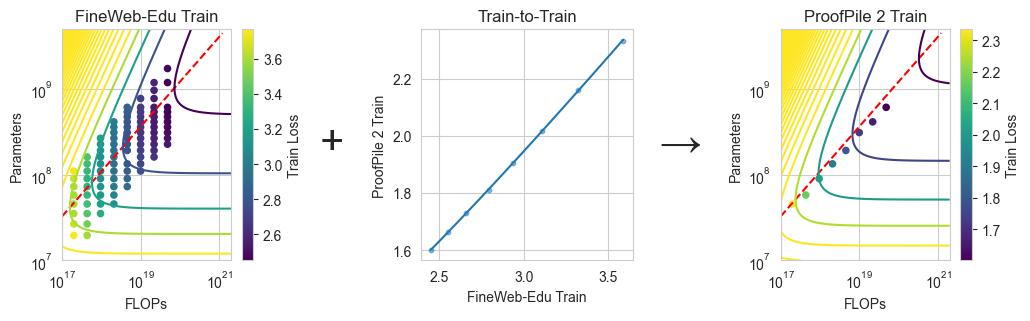

In [14]:
d1 = "fineweb-edu-100b"
d2 = "proof-pile-2"

params = translate_params(d1, d2)

plt.savefig("figures/translate_ours.pdf", bbox_inches="tight")
plt.show()

Loss: 8.791950856889936e-07
A = 64096431.883385874, B = 122571516.31482568, E = 0.9893408122491744, alpha = 0.2261391274263073, beta = 1.4856416136883897
G = 1.9160234347873397e-08, a = 0.8678924689390725, b = 0.13210753106092749
Loss: 9.712506468078742e-06
A = 21399832.68158203, B = 329014140.4916143, E = 1.3191056383496804, alpha = 0.45268444525949536, beta = 0.45522632660279727
G = 0.058861680124380894, a = 0.5013998519579672, b = 0.4986001480420328


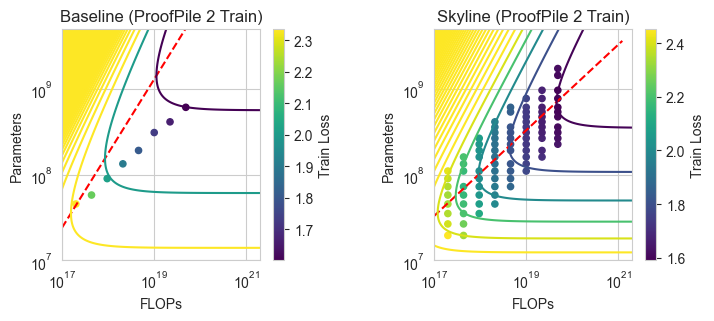

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
fig.subplots_adjust(wspace=0.5)

ax = axs[0]
id_params = plot_scaling(ax, chinchilla_df, d2, loss="val_loss", extrap=False, ncontour=600)
ax.set_title(f"Baseline ({display_dict[d2]} Train)")

ax = axs[1]
sky_params = plot_scaling(ax, df, d2, loss="val_loss", extrap=False)
ax.set_title(f"Skyline ({display_dict[d2]} Train)")

plt.savefig("figures/translate_baselines.pdf", bbox_inches="tight")
plt.show()

In [16]:
compute_r2(d2, id_params)

Array(0.92767214, dtype=float64)

In [17]:
losses = []
for d1 in datasets:
    for d2 in datasets:
        if d1 == d2:
            continue
        plt.ioff()
        params = translate_params(d1, d2)
        plt.close()
        plt.ion()
        loss = compute_r2(d2, params)
        losses.append((d1, d2, loss))

sky_losses = []
for d2 in datasets:
    plt.ioff()
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    sky_params = plot_scaling(ax, df, d2, loss="val_loss")
    id_params = plot_scaling(ax, chinchilla_df, d2, loss="val_loss")
    plt.close(fig)
    plt.ion()
    id_loss = compute_r2(d2, id_params)
    sky_loss = compute_r2(d2, sky_params)
    sky_losses.append((d2, id_loss, sky_loss))

Loss: 7.216911522038606e-06
A = 67873108.54367575, B = 931025251.4924387, E = 2.1700144171656954, alpha = 0.41072325854631786, beta = 0.45308760854630176
G = 0.012241320513350945, a = 0.5245217741602234, b = 0.4754782258397766
A = 57567995.73216791, B = 801921280.6120496, E = 2.0193105063977477, alpha = 0.4358042951593222, beta = 0.4807556469697134
G = 0.01224132051335097, a = 0.5245217741602234, b = 0.4754782258397766
Loss: 7.216911522038606e-06
A = 67873108.54367575, B = 931025251.4924387, E = 2.1700144171656954, alpha = 0.41072325854631786, beta = 0.45308760854630176
G = 0.012241320513350945, a = 0.5245217741602234, b = 0.4754782258397766
A = 19284475.317717154, B = 297556299.2184498, E = 1.3659317510945728, alpha = 0.47805545027534346, beta = 0.5273648282894952
G = 0.012241320513350947, a = 0.5245217741602233, b = 0.47547822583977656
Loss: 7.216911522038606e-06
A = 67873108.54367575, B = 931025251.4924387, E = 2.1700144171656954, alpha = 0.41072325854631786, beta = 0.45308760854630

In [18]:
print("Target Dataset & Skyline &  Ours (mean) & Baseline \\\\\midrule")
# mean losses
for d2, id_loss, sky_loss in sky_losses:
    loss = [l for l in losses if l[1] == d2]
    our_loss = np.mean([l[2] for l in loss])
    
    # R2
    tbf = '\\textbf'
    print(f"{display_dict[d2]} & {sky_loss:.3f} & {tbf}{{{our_loss:.3f}}} & {id_loss:.3f}  \\\\")

Target Dataset & Skyline &  Ours (mean) & Baseline \\\midrule
FineWeb & 0.992 & \textbf{0.990} & 0.961  \\
FineWeb-Edu & 0.992 & \textbf{0.990} & 0.953  \\
ProofPile 2 & 0.988 & \textbf{0.988} & 0.928  \\
SlimPajama & 0.992 & \textbf{0.991} & 0.975  \\
SmolLM Corpus & 0.992 & \textbf{0.991} & 0.947  \\
StarCoder & 0.987 & \textbf{0.986} & 0.450  \\


# Test-to-test

In [19]:
def plot_preds(d1, d2, key, show_plot=True, e_method="fit", ncontour=40):

    #e_method = "fit", "d1", "d2", or "oracle"
    
    if not show_plot:
        plt.ioff()
    fig, axs = plt.subplots(1, 4, figsize=(12, 3))
    fig.subplots_adjust(wspace=0.4)


    ax = axs[3]
    params = plot_scaling(ax, chinchilla_df, d2, loss=key, ncontour=ncontour)
    curve_params = [np.log(params["A"]), np.log(params["B"]), np.log(params["E"]), max(params["alpha"], 0),  max(params["beta"], 0), ]
    pred_scale = kaplan_curve(curve_params, df_big["params"][0], df_big["tokens"][0], np.ones(5), np.zeros(5))

    ax.set_title(f"Baseline: independent scaling")


    ax = axs[2]
    drop_df = chinchilla_df[chinchilla_df["data"] == d2]
    flop_key = "iso_flop"
    x = drop_df[flop_key]
    y = drop_df[key]

    add_x = df_big[df_big["data"] == d2][flop_key].values[0]
    add_y = df_big[df_big["data"] == d2][key].values[0]

    if e_method == "fit":
        E = None
    elif e_method == "d1":
        E = opt_params_df[(opt_params_df["data"] == d1) & (opt_params_df["loss_name"] == key)]["E"].values[0]
    elif e_method == "d2":
        E = params["E"]
    elif e_method == "oracle":
        E = opt_params_df[(opt_params_df["data"] == d2) & (opt_params_df["loss_name"] == key)]["E"].values[0]
    
    power_law = plot_with_power_law(ax, x, y, sns.color_palette()[0], display_dict[d2], ex=None, ey=E, add_x=add_x, geom=True)
    ax.scatter([add_x], [add_y], color=sns.color_palette()[0], marker="*", s=30, zorder=10, edgecolor="black", linewidth=0.2)

    ax.set_xlabel("FLOPs")
    ax.set_ylabel("Test Loss")
    ax.set_xscale("log")

    ax.set_title(f"Baseline: FLOPs-to-loss")

    pred_flops = power_law_with_constant(add_x, *power_law["params"][0])

    print("flops E: ", power_law["params"][0][-1])

    def plot_x_key(key1, ax):
        color=sns.color_palette()[0]
        x = df_big[df_big["data"] == d1][key1].values[0]
        y = df_big[df_big["data"] == d2][key].values[0]
        if e_method == "fit":
            kwargs = dict(fit_ey=True)
        elif e_method == "d1":
            kwargs = dict(fit_ey=False, ey="data_1")  # Use the entropy from the scaling law fit on data 1
        elif e_method == "d2":
            kwargs = dict(fit_ey=False, ey=params["E"])
        elif e_method == "oracle":
            kwargs = dict(fit_ey=False)
        power_law = plot_loss_diff_f(ax, chinchilla_df, d1, d2, key_1=key1, key_2=key,
                                    color=color, 
                            downstream=False, params=None, iso_flop=None, extrapolate=True,
                            add_x=x, **kwargs)
        ax.scatter([x], [y], color=color, marker="*", s=30, zorder=10, edgecolor="black", linewidth=0.2)
        return power_law

    key1 = "val_loss" # key
    ax = axs[0]
    power_law = plot_x_key(key1, ax)
    ax.set_xlabel(f"Train loss (Trained on {display_dict[d1]})")
    ax.set_ylabel(f"Test loss (Trained on {display_dict[d2]})")
    ax.set_title(f"General Train-to-Test")

    pred = power_law_with_constant(df_big[df_big["data"] == d1][key1].values[0], *power_law["params"][0])

    key1 = key
    ax = axs[1]
    power_law = plot_x_key(key1, ax)
    ax.set_xlabel(f"Test loss (Trained on {display_dict[d1]})")
    ax.set_ylabel(f"Test loss (Trained on {display_dict[d2]})")
    ax.set_title(f"Test-to-Test")

    test_pred = power_law_with_constant(df_big[df_big["data"] == d1][key1].values[0], *power_law["params"][0])

    if show_plot: 
        print(f"Loss-to-loss pred: {pred}")
        print(f"FLOPs pred: {pred_flops}")
        print(f"Scaling pred: {pred_scale}")
        print(f"Loss: {add_y}")
    else: 
        plt.close(fig)
        plt.ion()
        return add_y, pred, test_pred, pred_flops, pred_scale, df_big[df_big["data"] == d1][key].values[0]

Loss: 9.243212306754118e-07
A = 19974805184.127342, B = 12082554090.551943, E = 1.4637287086492081, alpha = 0.1490254187936022, beta = 0.3356995154987953
G = 1.3733870706923018e-06, a = 0.6925567301150913, b = 0.3074432698849087
flops E:  1.9667389898589165
Loss-to-loss pred: 2.7748588322179977
FLOPs pred: 2.8415922713876007
Scaling pred: 2.816719745774349
Loss: 2.825848340988159


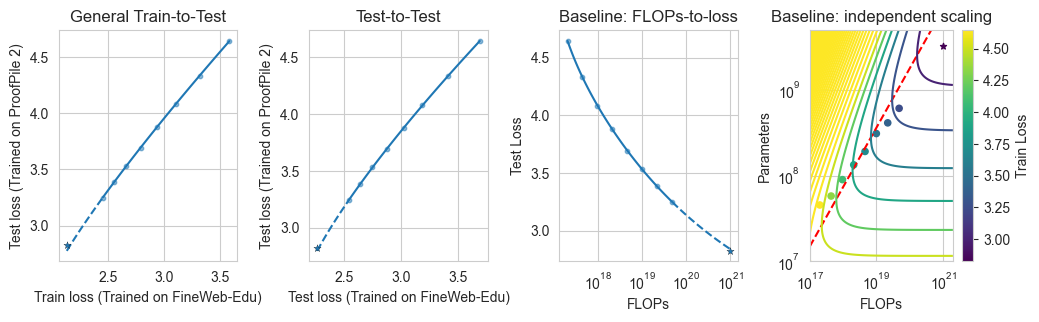

In [20]:
d1 = "fineweb-edu-100b"
d2 = "proof-pile-2"

key = "eval/downstream_ce_loss/hellaswag_test_ce_loss"

plot_preds(d1, d2, key, e_method="fit", ncontour=50)

plt.savefig("figures/test_extrapolation.pdf", bbox_inches="tight")
plt.show()

In [21]:
keys = [
        "eval/downstream_ce_loss/hellaswag_test_ce_loss",
        "eval/downstream_ce_loss/arc_easy_test_ce_loss",
        "eval/downstream_ce_loss/mmlu_humanities_test_ce_loss",
        "eval/downstream_ce_loss/mmlu_stem_test_ce_loss"
        ]

In [22]:
results_df = pd.DataFrame()
for e_method in ["fit"]: # ["fit", "d1", "d2", "oracle"]
    for d1 in ["fineweb-edu-100b"]: #datasets:
        for d2 in datasets:
            for key in keys:
                if d1 == d2:
                    continue
                loss, pred, test_pred, pred_flops, pred_scale, pred_id = plot_preds(d1, d2, key, show_plot=False, e_method=e_method)
                results_df = pd.concat([results_df, pd.DataFrame({
                    "data": d1, "target": d2, "loss": loss, "pred": pred, "flops": pred_flops, "scaling": pred_scale, "test": test_pred, "key": key, "down": key in test_losses, "e_method": e_method, "id": pred_id
                }, index=[0])])

Loss: 9.71010750638198e-08
A = 62086692.31988698, B = 1091628559.2389119, E = 1.9916069535937733, alpha = 0.41129981065401494, beta = 0.48900819951566205
G = 0.0027629885119411913, a = 0.5431565575246863, b = 0.45684344247531367
flops E:  2.0008455141626227
Loss: 6.615300494996595e-06
A = 4890786420.055106, B = 3671492.9362938623, E = 2.919244656165646, alpha = 0.2486223822464302, beta = 0.1701002480905089
G = 57837343.78466165, a = 0.40623609942847383, b = 0.5937639005715262
flops E:  2.5536780887179904
Loss: 1.9944752666240418e-06
A = 22612.11425464559, B = 29834009952.352688, E = 2.147102823678172, alpha = -0.004266983861355431, beta = 0.25831325848586556
G = -4.691750139630585e-13, a = 1.0167960890891323, b = -0.016796089089132254
flops E:  2.7058264029146444


/Users/davidbrandfonbrener/code/loss-to-loss-notebooks/utils_scaling.py:147: RuntimeWarning: invalid value encountered in power
  y = np.power(G * x / 6, a)


Loss: 3.9420764082038985e-06
A = 691112250.5525537, B = 4065642887.1712227, E = 2.4926421368638856, alpha = 0.302799245802469, beta = 0.16385382100759208
G = 9838155.60640937, a = 0.3511255634247969, b = 0.6488744365752032
flops E:  2.3065265694049875
Loss: 9.243212306754118e-07
A = 19974805184.127342, B = 12082554090.551943, E = 1.4637287086492081, alpha = 0.1490254187936022, beta = 0.3356995154987953
G = 1.3733870706923018e-06, a = 0.6925567301150913, b = 0.3074432698849087
flops E:  1.9667389898589165
Loss: 1.0785288956720452e-05
A = 7514080058.848343, B = 5121896.632239318, E = 3.2302802087461115, alpha = 0.2259878525153232, beta = 5.862775619096224
G = 1.8081261101393965e-08, a = 0.9628844422075227, b = 0.03711555779247731
flops E:  1.5151273843013882
Loss: 5.94741739145173e-06
A = 737969964270.9396, B = 2236712023.6459126, E = 1.8534112040369035, alpha = 0.12534148805010858, beta = 0.37974642772364353
G = 1.2196363869882264e-06, a = 0.7518422355084541, b = 0.24815776449154597
flo

In [23]:
results_df.head()

,data,target,loss,pred,flops,scaling,test,key,down,e_method,id
0,fineweb-edu-100b,fineweb-100b,2.209911,2.172968,2.243138,2.237915067927201,2.190320,eval/downstream_ce_loss/hellaswag_test_ce_loss,True,fit,2.261919
0,fineweb-edu-100b,fineweb-100b,3.327625,3.722011,3.989006,4.021184258473258,4.023068,eval/downstream_ce_loss/arc_easy_test_ce_loss,True,fit,2.537889
0,fineweb-edu-100b,fineweb-100b,3.075918,3.172116,3.211839,3.274818949953631,2.297008,eval/downstream_ce_loss/mmlu_humanities_test_c...,True,fit,2.928243
0,fineweb-edu-100b,fineweb-100b,2.857668,2.951803,3.134285,3.2138468739397137,3.057165,eval/downstream_ce_loss/mmlu_stem_test_ce_loss,True,fit,2.393446
0,fineweb-edu-100b,proof-pile-2,2.825848,2.774859,2.841592,2.816719745774349,2.798608,eval/downstream_ce_loss/hellaswag_test_ce_loss,True,fit,2.261919


In [24]:
def get_error(df, col):
    return np.mean(np.abs(df[col] - df["loss"]) / df["loss"]) * 100

In [25]:
print("Target Loss & General Train-to-Test & Test-to-Test & FLOPs-to-loss & Scaling law & Identity \\\\ \midrule")
for key in keys:
    results_df_key = results_df[(results_df["key"] == key)]
    # Assume we already fit on fineweb-edu-100b
    results_df_key = results_df_key[results_df_key["data"] == "fineweb-edu-100b"] 
    results_df_key = results_df_key[results_df_key["e_method"] == "fit"]

    train_fit = get_error(results_df_key, 'pred')
    test_fit = get_error(results_df_key, 'test')
    flops = get_error(results_df_key, 'flops')
    scaling = get_error(results_df_key, 'scaling')
    id = get_error(results_df_key, 'id')
    argmin = np.argmin([train_fit, test_fit, flops, scaling, id])
    tbf = '\\textbf'
    pct = "\\%"
    print(f"{val_display_dict[key]} & {tbf if argmin == 0 else ''}{{{train_fit:.1f}}}{pct} & {tbf if argmin == 1 else ''}{{{test_fit:.1f}}}{pct} & {tbf if argmin == 2 else ''}{{{flops:.1f}}}{pct} & {tbf if argmin == 3 else ''}{{{scaling:.1f}}}{pct} & {tbf if argmin == 4 else ''}{{{id:.1f}}}{pct} \\\\")

Target Loss & General Train-to-Test & Test-to-Test & FLOPs-to-loss & Scaling law & Identity \\ \midrule
Hellaswag & {1.6}\% & \textbf{1.2}\% & {1.7}\% & {2.1}\% & {9.2}\% \\
ARC-Easy & \textbf{10.2}\% & {17.6}\% & {14.3}\% & {16.8}\% & {24.8}\% \\
MMLU-Humanities & \textbf{2.8}\% & {23.1}\% & {4.4}\% & {4.7}\% & {11.0}\% \\
MMLU-STEM & {6.4}\% & {6.4}\% & \textbf{5.9}\% & {7.6}\% & {11.5}\% \\
